In [1]:
from mcculw import ul
from mcculw.enums import InterfaceType
from mcculw.device_info import DaqDeviceInfo
from mcculw.enums import ULRange,AnalogInputMode
import time
import numpy as np
from matplotlib import pyplot as plt
import json
import matplotlib.cm as cm
import pandas as pd

In [2]:
colors = ['tab:red', 'tab:orange', 'tab:olive', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:brown']

In [3]:
AI_name = 'USB-1608G'
AO_name = 'USB-3105'

In [4]:
ul.ignore_instacal()
devices = ul.get_daq_device_inventory(InterfaceType.ANY)

if not devices:
        raise Exception('Error: No DAQ devices found')

for d in devices:
    if d.product_name == AI_name:
        AI = d
    elif d.product_name == AO_name:
        AO = d

In [5]:
in_num = 0
ul.create_daq_device(in_num, AI)

out_num=1
ul.create_daq_device(out_num, AO)

In [6]:
#set ranges

ai_range = ULRange.BIP10VOLTS 
ai_range_Vr = ULRange.BIP1VOLTS 
ul.a_input_mode(in_num, AnalogInputMode.SINGLE_ENDED) # SE mode

daq_dev_info = DaqDeviceInfo(out_num)
ao_range = daq_dev_info.get_ao_info().supported_ranges[0]

In [7]:
out_V0_ch = 11
out_LED_ch = 13

out_Vg1_ch = 5
out_Vg2_ch = 7
out_Vg3_ch = 9
out_Vg4_ch = 0
out_Vg5_ch = 2
out_Vg6_ch = 4
out_Vg7_ch = 6
out_Vg8_ch = 8
out_Vg9_ch = 10
in_V0_ch = 7
in_V1_ch = 0
in_V2_ch = 1
in_V3_ch = 9
in_V4_ch = 2
in_V5_ch = 10
in_V6_ch = 3
in_V7_ch = 11
in_V8_ch = 14
in_V9_ch = 6
in_Vr_ch = 15

R0 = 100 #shunt resistance
GND = 0 #V
LED_supply = 3 #V
gain = 3.

Vg1 = 2.48
Vg2 = 2.53
Vg3 = 2.6
Vg4 = 2.62
Vg5 = 3#2.61
Vg6 = 3#2.42
Vg7 = 3#2.33
Vg8 = 3#2.43
Vg9 = 3#2.445

edgecomms = pd.DataFrame({'edge': pd.Series([1,2,3,4,5,6,7,8,9], dtype='int'), 
                          'out_Vg': pd.Series([out_Vg1_ch, out_Vg2_ch, out_Vg3_ch, out_Vg4_ch, out_Vg5_ch, out_Vg6_ch, out_Vg7_ch, out_Vg8_ch, out_Vg9_ch], dtype='int'), 
                          'in_dV':pd.Series([in_V1_ch, in_V2_ch, in_V3_ch, in_V4_ch, in_V5_ch, in_V6_ch, in_V7_ch, in_V8_ch, in_V9_ch], dtype='int'), 
                         'Vgg': pd.Series([Vg1, Vg2, Vg3, Vg4, Vg5, Vg6, Vg7, Vg8, Vg9], dtype='float')})
print(edgecomms)
for e in edgecomms.itertuples():
    ul.v_out(out_num, e.out_Vg, ao_range, e.Vgg)
ul.v_out(out_num, out_V0_ch, ao_range, 0)
ul.v_out(out_num, out_LED_ch, ao_range, LED_supply)

   edge  out_Vg  in_dV   Vgg
0     1       5      0  2.48
1     2       7      1  2.53
2     3       9      9  2.60
3     4       0      2  2.62
4     5       2     10  3.00
5     6       4      3  3.00
6     7       6     11  3.00
7     8       8     14  3.00
8     9      10      6  3.00


In [8]:
def V0_scan_updown(V0min=0.1, V0max=8.1, steps=100, nsamples=10, sleep=0, edgecomms= edgecomms):
    Nedges = len(edgecomms)
    out_dict = {'V{}'.format(x) : [] for x in edgecomms.edge}
    out_dict['Vr'] = []
    out_dict['V0'] = []
    V0s = np.linspace(V0min, V0max, steps)
    V0s_updown = np.concatenate((V0s, V0s[::-1][1:]), axis=-1)
    
    for V0 in V0s_updown:
        ul.v_out(out_num, out_V0_ch, ao_range, V0)
        sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
        sublists['Vr'] = []
        sublists['V0'] = []
        
        for n in range(nsamples):
            sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range_Vr))
            sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
            for e in edgecomms.itertuples():
                sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
            time.sleep(1./60./4.)

        out_dict['Vr'].append(np.mean(sublists['Vr']))
        out_dict['V0'].append(np.mean(sublists['V0']))
        for e in edgecomms.itertuples():
                out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))

        time.sleep(sleep)

    ul.v_out(out_num, out_V0_ch, ao_range, 0)
    return pd.DataFrame(out_dict)

In [9]:
def V0scan_piecewise(V0s =[], nsamples=10, sleep=0, edgecomms= edgecomms):
    Nedges = len(edgecomms)
    out_dict = {'V{}'.format(x) : [] for x in edgecomms.edge}
    out_dict['Vr'] = []
    out_dict['V0'] = []
    V0s = np.array(V0s)
    
    for V0 in V0s:
        ul.v_out(out_num, out_V0_ch, ao_range, V0)
        sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
        sublists['Vr'] = []
        sublists['V0'] = []
        
        for n in range(nsamples):
            sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range_Vr))
            sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
            for e in edgecomms.itertuples():
                sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
            time.sleep(1./60./4.)

        out_dict['Vr'].append(np.mean(sublists['Vr']))
        out_dict['V0'].append(np.mean(sublists['V0']))
        for e in edgecomms.itertuples():
                out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))

        time.sleep(sleep)

    # ul.v_out(out_num, out_V0_ch, ao_range, 0)
    return pd.DataFrame(out_dict)

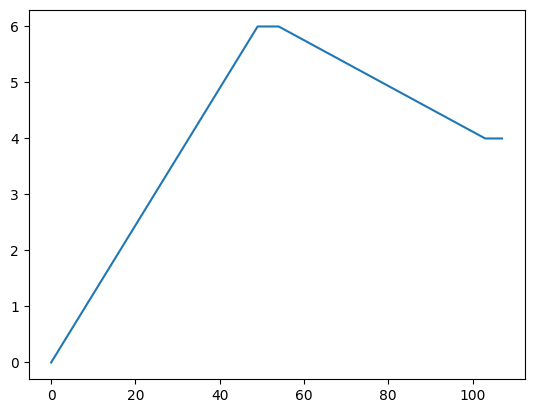

In [10]:
def generate_breakpoints(state = '10', ons = [4., 6.], offs = [4., 0.]):
    #assume 1 turns on first, then 2, etc
    #step 1: go up until you hit the last "1", truncate list
    #step 2: go down until you hit the LAST "0", truncate list
    #repeat

    breakpoints = [0.]

    localstate = (state+'0')[:-1]

    while localstate:
        laston = localstate.rfind('1')
        if laston == -1:
            break
        breakpoints.append(ons[laston])
        localstate= localstate[:laston]
        lastoff = localstate.rfind('0')
        if lastoff == -1:
            break
        breakpoints.append(offs[lastoff])
        localstate = localstate[:lastoff]

    return breakpoints

def generate_V0_sequence(breakpoints=[0.], steps=50, hold = 0):
    #steps = # steps between each breakpoint
    #hold = # steps to hold on each breakpoint (constant)
    
    if len(breakpoints) <=1:
        return breakpoints
    else:
        seq = np.array([])
        for previous, current in zip(breakpoints, breakpoints[1:]):
            seq = np.concatenate((seq, np.linspace(previous, current, steps)), axis=-1)
            seq = np.concatenate((seq, np.ones(hold)*current), axis=-1)
        return seq

plt.plot(generate_V0_sequence(generate_breakpoints('01'), hold=4))

In [11]:
def generate_V0seq_iterative(state = '10', V0step = 0.1, dV_thresh = 1.2, sleep=0, 
                             nsamples=3, rampdown=True, edgecomms = edgecomms):
    #assume 1 turns on first, then 2, etc
    #step 1: get index of last "1" in sequence. find voltage that switches the edge of that index on. set everything after to nan
    # step 2: get index of first "0" in sequence. find voltage that switches edge of that index off. set everything before to nan

    #check that state length == number of edges
    if len(state) != len(edgecomms):
        raise Exception('State length does not match number of edges')
        return None
    Nedges = len(state)

    out_dict = {'V{}'.format(x) : [] for x in edgecomms.edge}
    out_dict['Vr'] = []
    out_dict['V0'] = []
    
    breakpoints = [0.]
    current_V0 = 0.
    ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
    
    localstate = (state+'0')[:-1]
    print(localstate)
    while ((('1' in localstate) or ('0' in localstate)) and current_V0 < 10.):
        laston = localstate.rfind('1')
        if laston == -1:
            break
        else:
            localedge = edgecomms[edgecomms.edge == laston +1]
            in_ch = localedge.in_dV.values[0]
            switched = False
            while not(switched):
                current_V0 += V0step
                ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
                
                sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
                sublists['Vr'] = []
                sublists['V0'] = []
                for n in range(nsamples):
                    sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range))
                    sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
                    for e in edgecomms.itertuples():
                        sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
                    time.sleep(1./60./4.)
                out_dict['Vr'].append(np.mean(sublists['Vr']))
                out_dict['V0'].append(np.mean(sublists['V0']))
                for e in edgecomms.itertuples():
                        out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))
                
                current_dV = ul.v_in(in_num, in_ch, ai_range)
                
                if current_dV >= dV_thresh:
                    switched = True
                time.sleep(sleep)
            breakpoints.append(current_V0)
            localstate = localstate[:laston]
        print(localstate)
        lastoff = localstate.rfind('0')
        if lastoff == -1:
            break
        else:
            localedge = edgecomms[edgecomms.edge == lastoff + 1]
            in_ch = localedge.in_dV.values[0]
            switched = False
            while not(switched):
                current_V0 -= V0step
                ul.v_out(out_num, out_V0_ch, ao_range, current_V0)

                sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
                sublists['Vr'] = []
                sublists['V0'] = []
                for n in range(nsamples):
                    sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range))
                    sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
                    for e in edgecomms.itertuples():
                        sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
                    time.sleep(1./60./4.)
                out_dict['Vr'].append(np.mean(sublists['Vr']))
                out_dict['V0'].append(np.mean(sublists['V0']))
                for e in edgecomms.itertuples():
                        out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))
                
                current_dV = ul.v_in(in_num, in_ch, ai_range)
                if current_dV <= dV_thresh:
                    switched = True
                time.sleep(sleep)
            breakpoints.append(current_V0)
            localstate = localstate[:lastoff]
        print(localstate)

    if rampdown:
        V0rampdown(V0step = V0step, sleep=sleep)
    return breakpoints, pd.DataFrame(out_dict)

In [36]:
def V0rampdown(V0step = 0.1, sleep=0, V0tol = 0.01):
    current_V0 = ul.v_in(in_num, in_V0_ch, ai_range)
    final_V0 = V0tol
    while current_V0 > final_V0:
        ul.v_out(out_num, out_V0_ch, ao_range, current_V0 - V0step)
        current_V0 = ul.v_in(in_num, in_V0_ch, ai_range)

def V0rampto(V0final, V0step=0.1, sleep=0, V0tol=0.01, nsamples=2):
    Nedges = len(edgecomms)
    out_dict = {'V{}'.format(x) : [] for x in edgecomms.edge}
    out_dict['Vr'] = []
    out_dict['V0'] = []
    current_V0 = ul.v_in(in_num, in_V0_ch, ai_range)
    while np.abs(current_V0 - V0final) > V0tol:
        above = np.sign(V0final - current_V0)
        ul.v_out(out_num, out_V0_ch, ao_range, current_V0 + above*V0step)
        current_V0 = ul.v_in(in_num, in_V0_ch, ai_range)

        sublists = {'V{}'.format(x) : [] for x in edgecomms.edge}
        sublists['Vr'] = []
        sublists['V0'] = []
        
        for n in range(nsamples):
            sublists['Vr'].append(ul.v_in(in_num, in_Vr_ch, ai_range_Vr))
            sublists['V0'].append(ul.v_in(in_num, in_V0_ch, ai_range))
            for e in edgecomms.itertuples():
                sublists['V{}'.format(e.edge)].append(ul.v_in(in_num, e.in_dV, ai_range))
            time.sleep(1./60./4.)

        out_dict['Vr'].append(np.mean(sublists['Vr']))
        out_dict['V0'].append(np.mean(sublists['V0']))
        for e in edgecomms.itertuples():
                out_dict['V{}'.format(e.edge)].append(np.mean(sublists['V{}'.format(e.edge)]))
    return pd.DataFrame(out_dict)

In [13]:
def generate_V0seq_iterative02(state = '10', V0step = 0.1, dV_thresh = 1.2, sleep=0, 
                             nsamples=3, rampdown=True, edgecomms = edgecomms):
    #assume 1 turns on first, then 2, etc
    #step 1: get index of last "1" in sequence. find voltage that switches the edge of that index on. set everything after to nan
    # step 2: get index of first "0" in sequence. find voltage that switches edge of that index off. set everything before to nan

    #check that state length == number of edges
    if len(state) != len(edgecomms):
        raise Exception('State length does not match number of edges')
        return None
    Nedges = len(state)
    
    breakpoints = [0.]
    current_V0 = 0.
    ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
    
    localstate = (state+'0')[:-1]
    print(localstate)
    while ((('1' in localstate) or ('0' in localstate)) and current_V0 < 10.):
        laston = localstate.rfind('1')
        if laston == -1:
            break
        else:
            localedge = edgecomms[edgecomms.edge == laston +1]
            in_ch = localedge.in_dV.values[0]
            switched = False
            while not(switched):
                current_V0 += V0step
                ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
                current_dV = ul.v_in(in_num, in_ch, ai_range)

                if current_dV >= dV_thresh:
                    switched = True
                time.sleep(sleep)
            breakpoints.append(current_V0)
            localstate = localstate[:laston]
        print(localstate)
        lastoff = localstate.rfind('0')
        if lastoff == -1:
            break
        else:
            localedge = edgecomms[edgecomms.edge == lastoff + 1]
            in_ch = localedge.in_dV.values[0]
            switched = False
            while not(switched):
                current_V0 -= V0step
                ul.v_out(out_num, out_V0_ch, ao_range, current_V0)
                
                current_dV = ul.v_in(in_num, in_ch, ai_range)
                if current_dV <= dV_thresh:
                    switched = True
                time.sleep(sleep)
            breakpoints.append(current_V0)
            localstate = localstate[:lastoff]
        print(localstate)

    if rampdown:
        V0rampdown(V0step = V0step, sleep=sleep)
    return generate_V0_sequence(breakpoints)

In [47]:
out_V0_ch = 11
out_LED_ch = 13

out_Vg1_ch = 5
out_Vg2_ch = 7
out_Vg3_ch = 9
out_Vg4_ch = 0
out_Vg5_ch = 2
out_Vg6_ch = 4
out_Vg7_ch = 6
out_Vg8_ch = 8
out_Vg9_ch = 10
in_V0_ch = 7
in_V1_ch = 0
in_V2_ch = 1
in_V3_ch = 9
in_V4_ch = 2
in_V5_ch = 10
in_V6_ch = 3
in_V7_ch = 11
in_V8_ch = 14
in_V9_ch = 6
in_Vr_ch = 15

R0 = 100 #shunt resistance
GND = 0 #V
LED_supply = 3 #V
gain = 3.

# Vg1 = 2.48
# Vg2 = 2.53
# Vg3 = 2.6
# Vg4 = 2.62
# Vg5 = 2.4
# Vg6 = 2.48
# Vg7 = 2.38
# Vg8 = 2.52
# Vg9 = 2.52

Vg1 = 2.48
Vg2 = 2.53
Vg3 = 2.6
Vg4 = 2.62
Vg5 = 2.4
Vg6 = 2.47
Vg7 = 2.36
Vg8 = 2.48
Vg9 = 2.5

edgecomms = pd.DataFrame({'edge': pd.Series([1,2,3,4,5,6,7,8,9], dtype='int'), 
                          'out_Vg': pd.Series([out_Vg1_ch, out_Vg2_ch, out_Vg3_ch, out_Vg4_ch, out_Vg5_ch, out_Vg6_ch, out_Vg7_ch, out_Vg8_ch, out_Vg9_ch], dtype='int'), 
                          'in_dV':pd.Series([in_V1_ch, in_V2_ch, in_V3_ch, in_V4_ch, in_V5_ch, in_V6_ch, in_V7_ch, in_V8_ch, in_V9_ch], dtype='int'), 
                         'Vgg': pd.Series([Vg1, Vg2, Vg3, Vg4, Vg5, Vg6, Vg7, Vg8, Vg9], dtype='float')})
print(edgecomms)
for e in edgecomms.itertuples():
    ul.v_out(out_num, e.out_Vg, ao_range, e.Vgg)
ul.v_out(out_num, out_V0_ch, ao_range, 0)
ul.v_out(out_num, out_LED_ch, ao_range, LED_supply)

   edge  out_Vg  in_dV   Vgg
0     1       5      0  2.48
1     2       7      1  2.53
2     3       9      9  2.60
3     4       0      2  2.62
4     5       2     10  2.40
5     6       4      3  2.47
6     7       6     11  2.36
7     8       8     14  2.48
8     9      10      6  2.50


In [97]:
V0rampdown()

ul.v_out(out_num, out_V0_ch, ao_range, 0.)

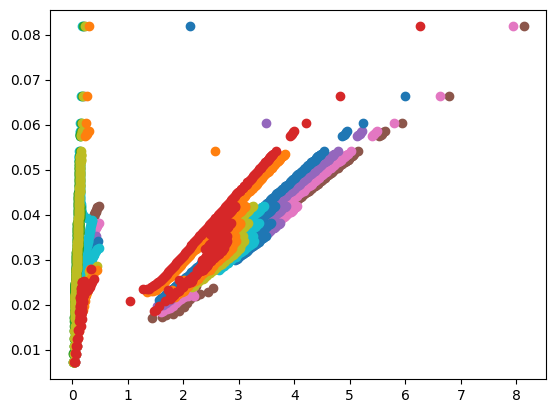

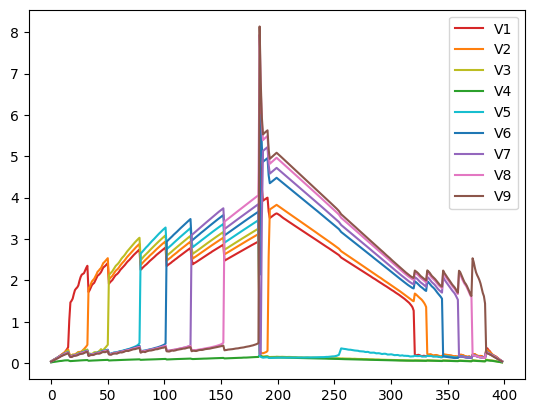

In [101]:
outd = V0_scan_updown(V0max=9, steps=200, nsamples=3)

for i in range(len(edgecomms)):
    plt.scatter(outd['V{}'.format(i+1)], outd.Vr, zorder = -1*i, color=colors[i])
plt.show()

for i in range(len(edgecomms)):
    plt.plot(outd['V{}'.format(i+1)], label='V{}'.format(i+1), color=colors[i])
plt.legend()
plt.show()

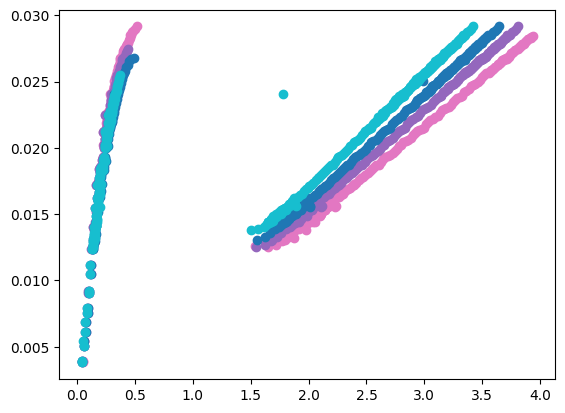

In [24]:
for i in range(4,8):
    plt.scatter(outd['V{}'.format(i+1)], outd.Vr, zorder = -1*i, color=colors[i])
plt.show()

010111010
0101110
010111
01011
01
0



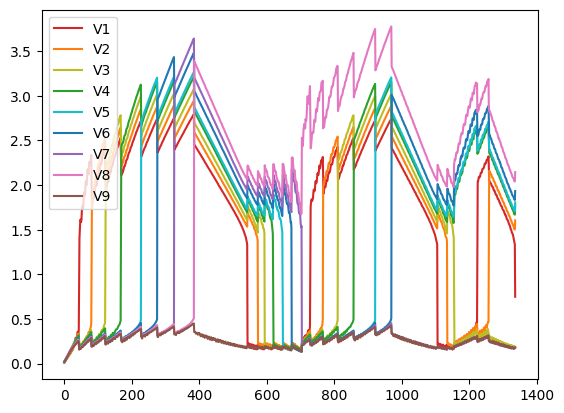

In [88]:
seq = '010111010' # cross pattern
# seq = '101010101' # X pattern
# seq = '101010101'

ul.v_out(out_num, out_V0_ch, ao_range, 0.)
V0seq, outd = generate_V0seq_iterative(seq, V0step = 0.02, dV_thresh=1., sleep=0.01, nsamples=2, rampdown=False)

for i in range(len(edgecomms)):
    plt.plot(outd['V{}'.format(i+1)], label='V{}'.format(i+1), color=colors[i])
plt.legend()

In [95]:
# time.sleep(2)
out2 = V0rampto(11.98/gain, V0step=0.02, sleep=0.1)
# V0rampdown()

In [59]:
outd = pd.concat([outd,out2])

In [60]:
np.max(outd.V0*gain)
outd

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Vr,V0
0,0.009308,0.006561,0.013123,0.016632,0.016022,0.020294,0.018005,0.025024,0.020599,0.001221,0.020599
1,0.016785,0.016479,0.021362,0.023346,0.021667,0.028381,0.025024,0.032654,0.026855,0.001831,0.039978
2,0.022888,0.022583,0.030365,0.027924,0.028076,0.033722,0.031891,0.039062,0.033569,0.002899,0.060425
3,0.029449,0.025940,0.036011,0.037842,0.035706,0.042725,0.037842,0.045624,0.041351,0.003510,0.080414
4,0.037842,0.033112,0.043182,0.041504,0.042877,0.048523,0.045929,0.052490,0.047150,0.004578,0.100708
...,...,...,...,...,...,...,...,...,...,...,...
22,0.238037,1.937408,0.237427,2.123566,2.158661,2.303467,0.214081,2.545929,0.213318,0.018280,3.918915
23,0.259705,1.938324,0.246887,2.127686,2.162170,2.309113,0.216522,2.558136,0.213928,0.018326,3.939362
24,0.277557,1.941223,0.259857,2.130585,2.167053,2.314911,0.219727,2.567139,0.216675,0.018402,3.958740
25,0.285950,1.948090,0.265198,2.135315,2.169800,2.318420,0.225067,2.572021,0.223541,0.018524,3.978424


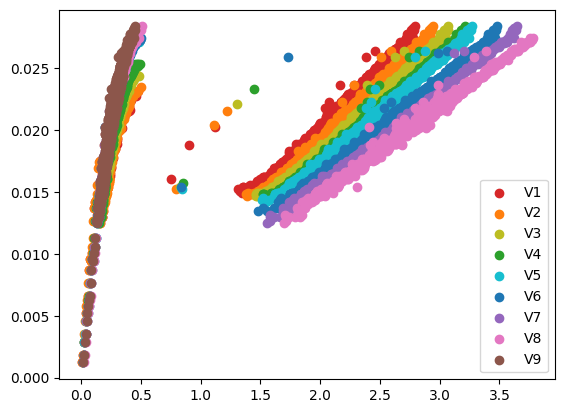

In [61]:
for i in range(len(edgecomms)):
    plt.scatter(outd['V{}'.format(i+1)], outd.Vr, label='V{}'.format(i+1), color=colors[i])
plt.legend()
plt.show()

In [62]:
outd['R0'] = R0
outd['V0gain'] = gain
outd['RL1'] = 10e3
outd['RL2'] = 10.5e3
outd['RL3'] = 11e3
outd['RL4'] = 11.7e3
outd['RL5'] = 12e3
outd['RL6'] = 12.5e3
outd['RL7'] = 13e3
outd['RL8'] = 13.7e3
outd['RL9'] = 14e3
for e in edgecomms.itertuples():
    outd['Vg{}'.format(e.edge)] = e.Vgg

outd
# outd.to_csv('sequences/9NDR/V0scan_updown_0925_02.csv')
outd.to_csv('sequences/9NDR/{}_0925_02.csv'.format(seq))

In [96]:
V0rampdown()

In [16]:
ul.release_daq_device(in_num)
ul.release_daq_device(out_num)